# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [50]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
%matplotlib inline

In [51]:
data_dir = "/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord"
dataset = get_dataset(data_dir)

INFO:tensorflow:Reading unweighted datasets: ['/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [62]:
def class_to_color_name(class_id):
    # Takes in a class and return its color and name
    colors = {1:'red',2:'blue',4:'green'}
    names = {1:'vehicle',2:'pedestrain',4:'cyclist'}
    return colors[class_id],names[class_id]

In [63]:
def draw_bbox(image,class_id,bbox):
    color,name = class_to_color_name(class_id)
    y1,x1,y2,x2 = bbox
    y1 *= image.shape[0]
    y2 *= image.shape[0]
    x1 *= image.shape[1]
    x2 *= image.shape[1]
    plt.gca().add_patch(patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth = 1, edgecolor = color, facecolor = 'none'))
    plt.annotate(class_id,(x1,y1))
    

In [64]:
def display_image(image,classes,bboxes):
    plt.imshow(image)
    for (box,class_id) in zip(bboxes,classes):
        draw_bbox(image,class_id,box)

In [65]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    data = dataset.take(batch)
    for element in data:
        image = element["image"].numpy()
        display_image(image,element["groundtruth_classes"].numpy(),element["groundtruth_boxes"].numpy())
        plt.show()
        
    # ADD CODE HERE

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

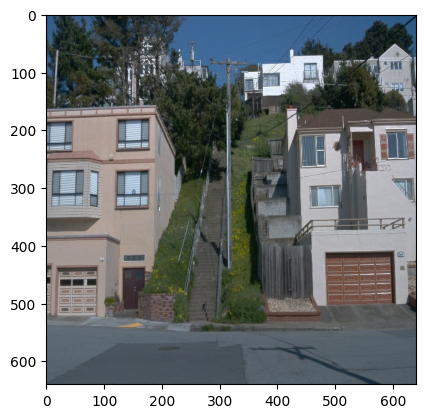

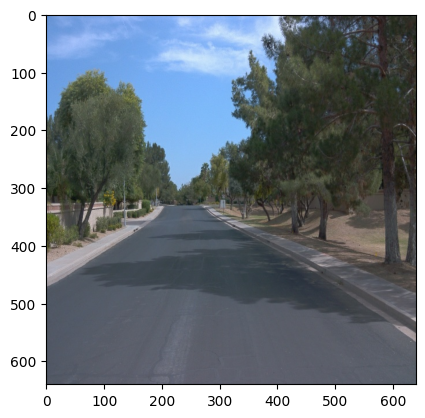

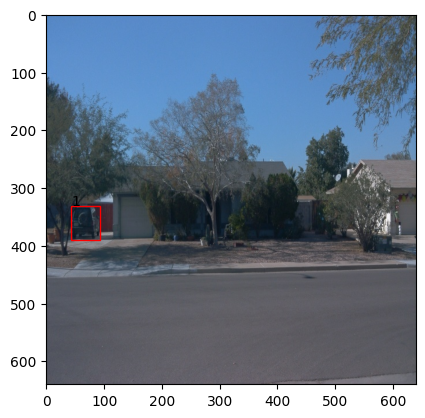

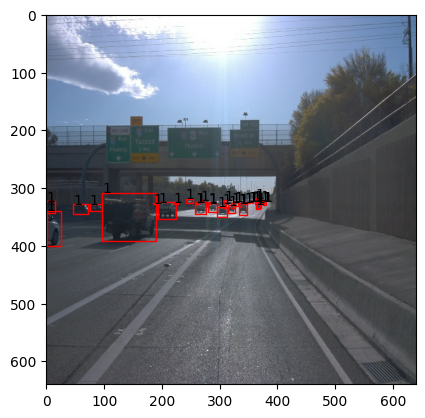

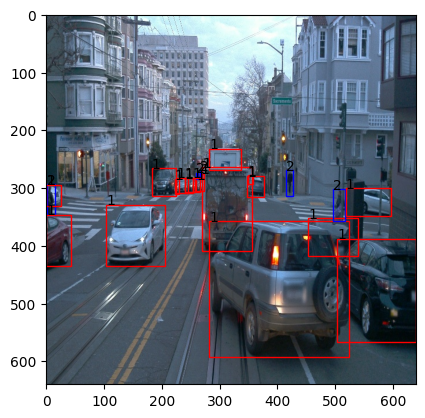

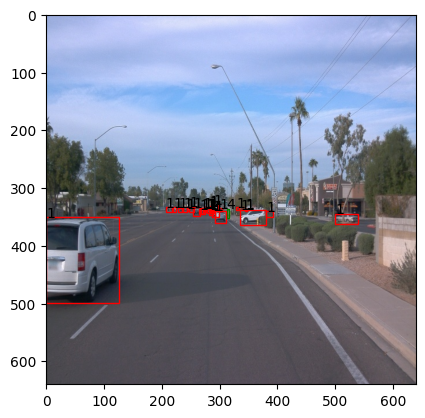

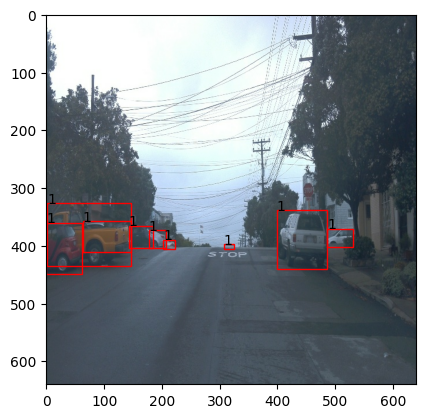

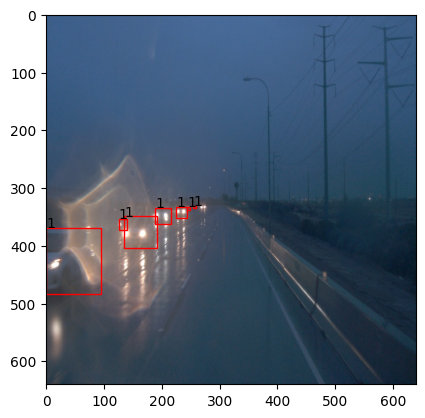

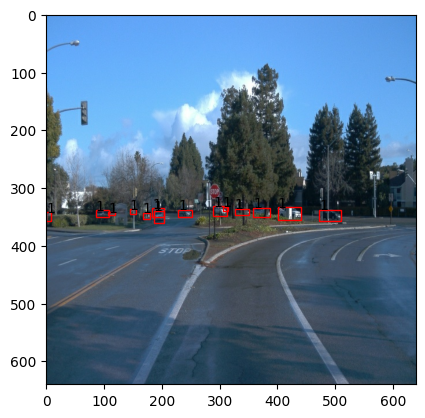

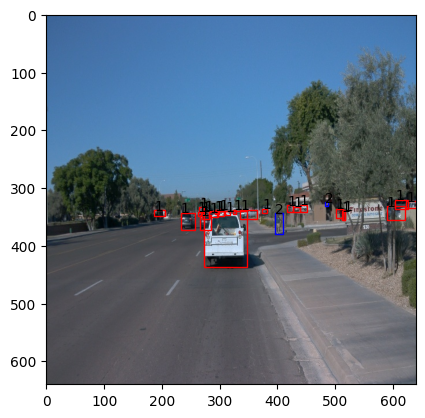

In [66]:
## STUDENT SOLUTION HERE
display_instances(10)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...